In [1]:
import xarray as xr
import now
import numpy as np
from datetime import date
from matplotlib import pyplot as plt
from dask.distributed import LocalCluster, Client
import dask as da
import math
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
cluster = LocalCluster(processes=False, local_dir= "/g/data1a/e14/rm6294/dask-workers")
client = Client(cluster)
client

/g/data1/e14/rm6294/miniconda3/envs/now-postprocess/lib/python3.6/site-packages/distributed/bokeh/core.py:57: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn('\n' + msg)


Client Scheduler: inproc://10.0.64.22/12820/1 Dashboard: http://localhost:43238/status,Cluster Workers: 1 Cores: 8 Memory: 33.67 GB


In [3]:
# Opens Climatology and MHW SST threshold files, that have been created before.
# Note: p stands for past, f for future
localDir = "/g/data1a/e14/rm6294/NOWMHW/orig/"
pThresh = xr.open_dataarray(localDir + 'pastThresh.nc')
pClim = xr.open_dataarray(localDir + 'pastClim.nc')
fThresh = xr.open_dataarray(localDir + 'futureThresh.nc')
fClim = xr.open_dataarray(localDir + 'futureClim.nc')

In [4]:
# Opens NOW SST data, from which we need the SST.
cfg = 'present_vs_future.ini'
sst = now.io.open_nemo_griddata_from_zarr(cfg, grid='T')['tos'] #tos means sst
# SST contains both future and past run. We now split that up.
sstPast = sst.sel(simulation = 'Present')
sstFut = sst.sel(simulation = 'Future')

In [5]:
# NOW data is daily, and runs from 1990/01/01T12:00:00 to 2008/12/31T12:00:00. We use this to create our t vector.
#Two lines below taken from example_synthetic file in MHW github
t = np.arange(date(1990,1,1).toordinal(),date(2008,12,31).toordinal()+1)
dates = [date.fromordinal(tt.astype(int)) for tt in t]

In [6]:
def fix(ds, name):
    # This was the code fixed to make the clim and thresh repeatable.
    trial = ds
    i = 0
    while i < 19:
        trial = xr.concat([trial, ds], 'dayofyear')
        i+=1
    trial = trial.isel(dayofyear = slice(0,6940))
    trial.coords['dayofyear'] = t
    
    # This code was used to rename the dayofyear dimension to time_counter.
    trial['time_counter'] = trial['dayofyear']
    del trial['dayofyear']
    trial = trial.rename({'dayofyear': 'time_counter'})
    trial.name = name
    
    trial['time_counter'] = sstPast['time_counter']
    trial.coords['simulation'] = ds.coords['simulation']
    trial = trial.chunk({'time_counter' : 365})
    return trial

In [14]:
pThreshFix = fix(pThresh, "90th percentile for past NOW Run")
pThreshFix

<xarray.DataArray '90th percentile for past NOW Run' (time_counter: 6940, y: 289, x: 431)>
dask.array<shape=(6940, 289, 431), dtype=float64, chunksize=(365, 289, 431)>
Coordinates:
    nav_lat          (y, x) float32 dask.array<shape=(289, 431), chunksize=(289, 431)>
    nav_lon          (y, x) float32 dask.array<shape=(289, 431), chunksize=(289, 431)>
    simulation       |S7 ...
  * time_counter     (time_counter) datetime64[ns] 1990-01-01T12:00:00 ... 2008-12-31T12:00:00
    time_maximum_1d  (time_counter) datetime64[ns] dask.array<shape=(6940,), chunksize=(365,)>
    time_minimum_1d  (time_counter) datetime64[ns] dask.array<shape=(6940,), chunksize=(365,)>
Dimensions without coordinates: y, x

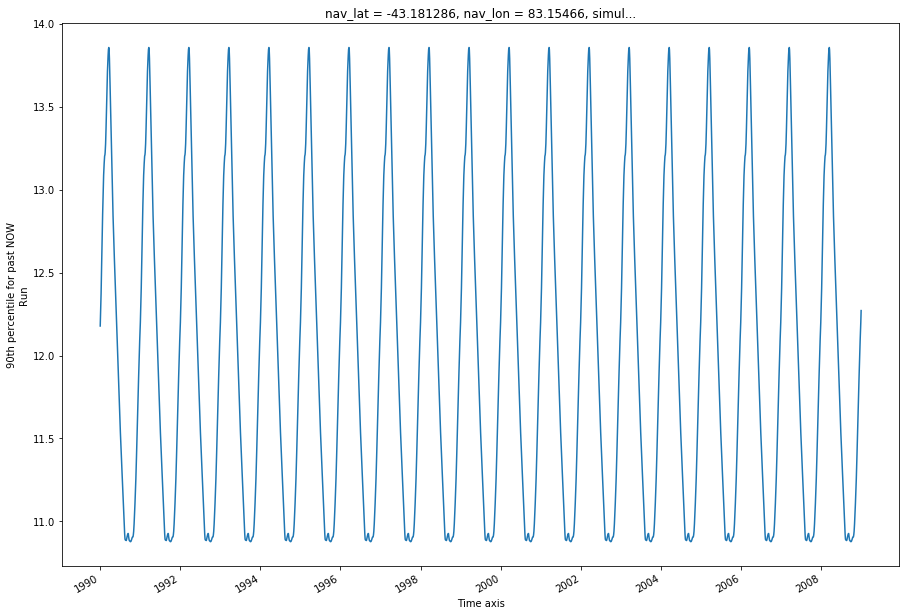

In [15]:
pThreshFix.isel(x=1,y=1).plot(size = 10)

In [16]:
pThreshFix.to_netcdf('/g/data1a/e14/rm6294/NOWMHW/pastThreshRep.nc')